In [1]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle
import pandas as pd

# Helper functions

In [288]:
def plot_hist(returns):
    
    zeta = 0.05
    alpha = 0.05
    
    sns.kdeplot(returns)
    
    p = np.mean(returns >= zeta)
    var = np.quantile(returns, alpha)
    cvar = float(np.sum(returns * (returns <= var)) / np.sum(returns <= var)) / (1 - alpha)

    plt.axvline(var, c='y', linestyle='--', label=f'VaR={var:4.2}')
    plt.axvline(cvar, c='r', linestyle='--', label=f'CVaR={cvar:4.2}')
    plt.axvline(zeta, c='g', linestyle='--', label=f'P={p}')
    plt.legend()

In [289]:
def plot_2d(returns):
    
    n_assets = returns.shape[1]
    
    fig, ax = plt.subplots(nrows=n_assets, ncols=n_assets, figsize=(2 * n_assets + 2, 2 * n_assets), constrained_layout=True)
    fig.suptitle('2D marginals', fontsize=20)

    for i in range(n_assets):
        for j in range(n_assets):
            if i < j:
                ax[i][j].hist2d(returns[:, i], returns[:, j], bins=50, range=[[-0.3, 0.3], [-0.3, 0.3]], cmap='viridis')
            if i > j:
                fig.delaxes(ax[i][j])
        sns.kdeplot(data=returns[:, i], ax=ax[i][i], fill=True, label='train')
        ax[i][i].legend()

# Generate returns

In [290]:
T = 60
Rx = 100.
Ry = 1000.
batch_size = 1_000

kappa = [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
sigma = [1, 0.3, 0.5, 1.5, 1.75, 2, 2.25]
p = [0.35, 0.3, 0.34, 0.33, 0.32, 0.31, 0.3]
phi = np.repeat(0.03, 7)

In [291]:
''' Initial reserves '''
Rx0   = np.repeat(Rx, len(kappa))
Ry0   = np.repeat(Ry, len(kappa))

pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

xs_0 = np.repeat(1., len(kappa))
l = pools.swap_and_mint(xs_0)
end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.97it/s]


In [292]:
x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
log_ret = np.log(x_T)
Y = pd.DataFrame(log_ret)
Y

,0,1,2,3,4,5,6
0,0.109121,0.084322,0.267250,-0.067791,0.015845,1.184843,-0.019499
1,0.117689,0.149576,0.219760,0.120858,0.153957,0.414518,-0.009167
2,0.120731,0.028758,0.261596,1.033033,0.050901,0.187078,0.047434
3,0.142258,0.153706,0.170335,0.253819,0.171851,0.204842,0.052555
4,0.047293,-0.002309,-0.070226,0.038009,0.141635,-0.030689,0.018649
...,...,...,...,...,...,...,...
995,0.161513,0.079956,0.152224,-0.275855,0.195518,-0.006171,0.041828
996,0.161656,0.029089,0.039549,0.159172,0.046602,0.073144,-0.017676
997,0.057555,0.045898,0.000496,-0.110599,0.054333,-0.103568,-0.032645
998,0.146578,-0.022299,0.086821,-0.004528,0.244827,0.290371,-0.001988


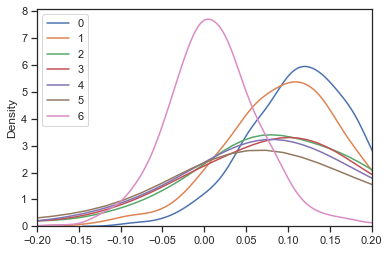

In [293]:
# 1d marginals on top of each other

for i in range(log_ret.shape[1]):
    sns.kdeplot(log_ret[:, i], label=i)
    
plt.xlim((-0.2, 0.2))
plt.legend()

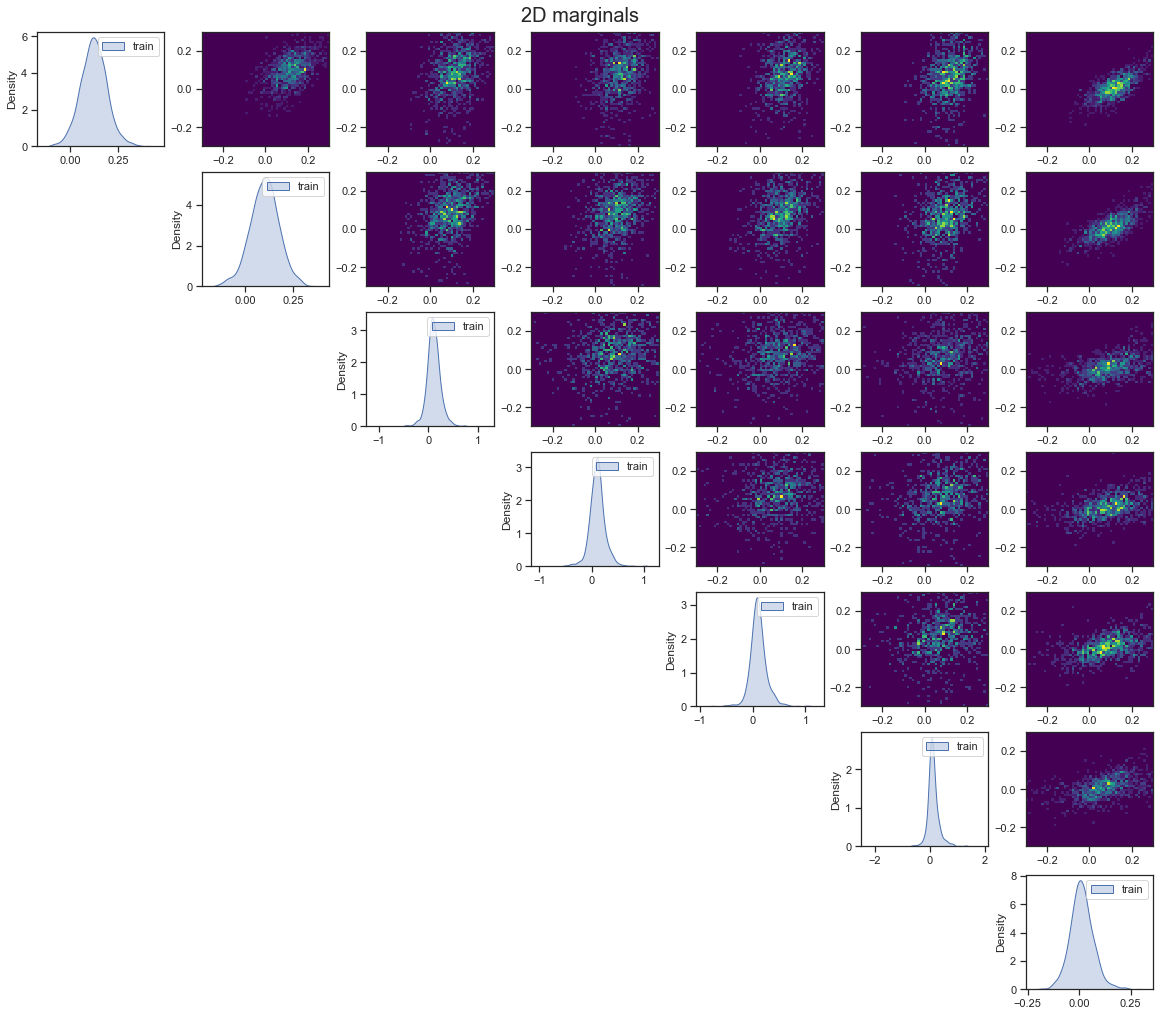

In [294]:
plot_2d(log_ret)

# Average of quantiles vs. quantiles of averages

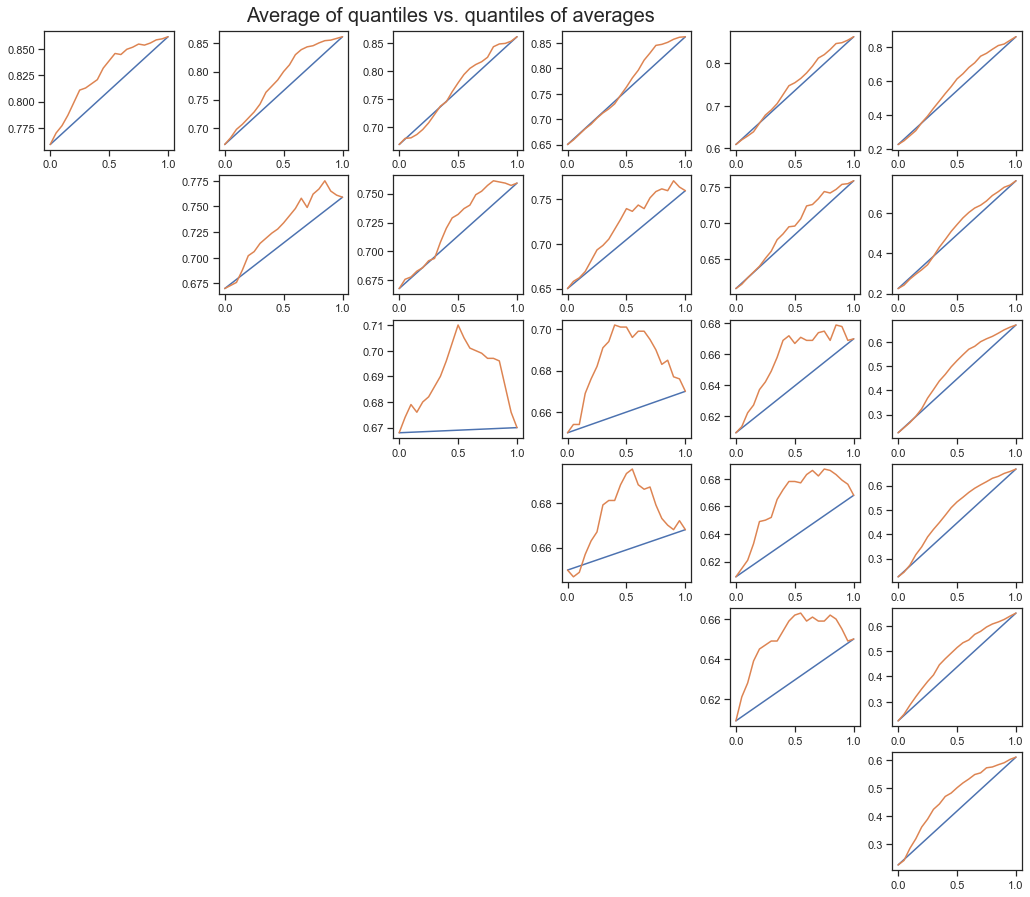

In [295]:
n_assets = 7

fig, ax = plt.subplots(nrows=n_assets, ncols=n_assets, figsize=(2 * n_assets + 2, 2 * n_assets), constrained_layout=True)
fig.suptitle('Average of quantiles vs. quantiles of averages', fontsize=20)

for i in range(n_assets):
    for j in range(n_assets):
        if i < j:
            q0, q1 = np.mean(log_ret[:, i] >= 0.05), np.mean(log_ret[:, j] >= 0.05)

            ws = np.linspace(0, 1, 21)
            ps0 = ws * q0 + (1 - ws) * q1
            ps1 = np.mean(ws[:, None] @ log_ret[:, i][None, :] + ((1 - ws[:, None]) @ log_ret[:, j][None, :]) >= 0.05, axis=1)

            ax[i][j].plot(ws, ps0)
            ax[i][j].plot(ws, ps1)
            
        if i >= j:
            fig.delaxes(ax[i][j])


# Correlation of returns

In [296]:
df = pd.DataFrame(log_ret)
mean = pd.DataFrame(df.mean(axis=0)).T
display(mean.style.background_gradient(cmap='coolwarm', axis=None))
corr = df.corr()
display(corr.style.background_gradient(cmap='coolwarm', axis=None))

,0,1,2,3,4,5,6
0,0.121659,0.099129,0.102485,0.101956,0.101870,0.109624,0.011680


,0,1,2,3,4,5,6
0,1.000000,0.499247,0.281160,0.195001,0.196805,0.184291,0.721614
1,0.499247,1.000000,0.271915,0.171558,0.190190,0.129133,0.708985
2,0.281160,0.271915,1.000000,0.147750,0.145957,0.066786,0.380239
3,0.195001,0.171558,0.147750,1.000000,0.117084,0.085010,0.296409
4,0.196805,0.190190,0.145957,0.117084,1.000000,0.063009,0.301520
5,0.184291,0.129133,0.066786,0.085010,0.063009,1.000000,0.214233
6,0.721614,0.708985,0.380239,0.296409,0.301520,0.214233,1.000000


# Optimization with riskfolio

In [297]:
import riskfolio as rp
import pandas as pd

Portfolio weights:


,0,1,2,3,4,5,6
weights,0.676062,0.229646,0.017478,0.035875,0.027266,0.013671,1.033150e-14


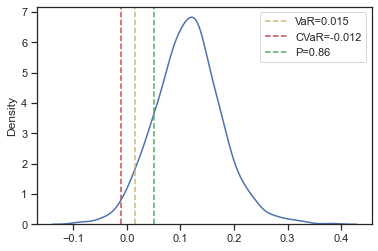

In [298]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

print("Portfolio weights:")
display(weights.T)

portfolio_returns = log_ret @ weights
portfolio_returns = portfolio_returns.to_numpy().T[0]
plot_hist(portfolio_returns)

# Optimization by hand

1. Adjust code from `riskfolio/src/Portfolio.py`, and incorporate our constraints P(ret >= 0.5) >= 0.7
2. Check if this constraint can be accommodated by riskfolio library

Objective: 224.72930812809804
Portfolio weights:


,0,1,2,3,4,5,6
0,0.555747,0.217143,0.043479,0.064918,0.056981,0.035339,0.026393


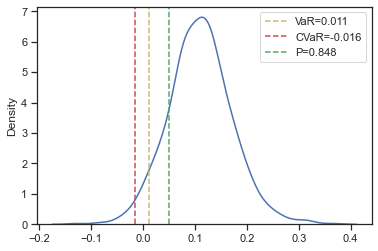

In [305]:
# pseudocode:
# reference file: riskfolio/src/Portfolio.py

import cvxpy as cp
import numpy as np

returns = log_ret
alpha = 0.05

n_returns, n_assets = returns.shape

weights = cp.Variable((n_assets, 1))
k = cp.Variable((1, 1))
var = cp.Variable((1, 1))
Z1 = cp.Variable((n_returns, 1))
log_w = cp.Variable((n_assets, 1))

X = returns @ weights
cvar = var + 1 / (alpha * n_returns) * cp.sum(Z1)

constraints = [
    # rb.T @ cp.log(w) >= 1,
    np.ones((1, n_assets)) @ log_w >= 1,
    cp.ExpCone(log_w * 1000, np.ones((n_assets, 1)) * 1000, weights * 1000),
    weights * 1000 >= 0,
    cp.sum(weights) * 1000 == k * 1000,
]

# CVaR constraints
constraints += [Z1 * 1000 >= 0, Z1 * 1000 >= -X * 1000 - var * 1000]

# lower bound: average of emp cdf:
# might not be a valid constraint!
emp_cdf_005 = np.mean(log_ret >= 0.05, axis=0)
constraints += [emp_cdf_005 @ weights * 1000 >= k * 0.7 * 1000]

# naive idea for the return constraint:
# constraints += [cp.sum(returns @ weights >= 0.05) >= 0.7 * n_returns]

objective = cp.Minimize(cvar * 1000)

# possible solvers: "ECOS", "SCS", "OSQP", "CVXOPT"
prob = cp.Problem(objective, constraints)
result = prob.solve(solver="SCS")

print(f"Objective: {result}")

portfolio_weights = (weights.value / k.value).T[0]
portfolio_returns = returns @ portfolio_weights

print("Portfolio weights:")
display(pd.DataFrame(portfolio_weights).T)
plot_hist(portfolio_returns)